In [2]:
import numpy as np
import pandas as pd
import seaborn as sns #for plotting

#for data fetching
import xenaPython as xena

# for survival analysis
import lifelines
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter

/Users/anne/anaconda/envs/psc/lib/python3.7/site-packages/xenaPython/__init__.py:110: FutureWarning: Possible nested set at position 7
  re.sub(r"^[^[]+[[]([^]]*)[]].*$", r"\1", query, flags=re.DOTALL))


# Fetch the data on TCGA (using XenaPython)

In [133]:
def get_codes(host, dataset, fields, data):
    "get codes for enumerations"
    codes = xena.field_codes(host, dataset, fields)
    codes_idx = dict([(x['name'], x['code'].split('\t')) for x in codes if x['code'] is not None])
    for i in range(len(fields)):
        if fields[i] in codes_idx:
            data[i] = [None if v == 'NaN' else codes_idx[fields[i]][int(v)] for v in data[i]]
    return data

def get_fields(host, dataset, samples, fields):
    "get field values"
    data = xena.dataset_fetch(host, dataset, samples, fields)
    return data

def get_fields_and_codes(host, dataset, samples, fields):
    "get fields and resolve codes"
    return get_codes( host, dataset, fields, get_fields( host, dataset, samples, fields))

### Gene expression data

In [134]:

hub = "https://gdc.xenahubs.net"
dataset = "TCGA-BRCA/Xena_Matrices/TCGA-BRCA.htseq_fpkm-uq.tsv" #database url was found on the hub website
samples = xena.dataset_samples (hub, dataset, None)
genes =["NCKAP1", "ARPIN", "PICK1", "WASF1", "CYFIP1", "ABI1", "BRK1"] #enter the genes of interest
fields = ["sampleID"]
expressions_0 = xena.dataset_gene_probe_avg(hub, dataset, samples, genes)

values = get_fields_and_codes(hub, dataset, samples, fields) # list of lists

genes_dict_for_df = dict(zip(fields, values)) #dict where we add the gene expression and the sample ids

In [135]:
for dico in expressions_0:
    label = "expression" + dico["gene"]
    scores = dico["scores"][0]
    assert len(scores) > 0
    genes_dict_for_df[label] = scores

### Survival data

In [136]:
dataset = "TCGA-BRCA/Xena_Matrices/TCGA-BRCA.survival.tsv"
fields = ['_TIME_TO_EVENT', "_EVENT", "sampleID"] #event is one if the patient has died or 0 if he was censored (lost...)
#TODO
# As in pancan, there are normal samples in tcga which should probably be removed. _sample_type will
# identify normals. _study will identify tcga vs. gtex vs. target.
values = get_fields_and_codes(hub, dataset, samples, fields) # list of lists
survival_dict_for_df = dict(zip(fields, values)) # index by phenotype

In [137]:
survival_dict_for_df["survival"] = survival_dict_for_df.pop("_TIME_TO_EVENT") 
survival_dict_for_df["event"] = survival_dict_for_df.pop("_EVENT")

### Phenotype data

In [138]:
dataset = "TCGA-BRCA/Xena_Matrices/TCGA-BRCA.GDC_phenotype.tsv"
fields = ['sample_type.samples', "sampleID"] 
values = get_fields_and_codes(hub, dataset, samples, fields) # list of lists
phenotype_dict_for_df = dict(zip(fields, values)) # index by phenotype

In [139]:
phenotype_dict_for_df["sample_type"] = phenotype_dict_for_df.pop('sample_type.samples')

Note : I don't know if it's useful to remove the patients whose tumor is not a "Primary Tumor", like advised by Xena. The goal is to remove duplicates but I can't find duplicates

### Merge data

In [141]:
df_genes = pd.DataFrame(data=genes_dict_for_df)
df_survival = pd.DataFrame(data=survival_dict_for_df)
#df_phenotype = pd.DataFrame(data=phenotype_dict_for_df)

df = pd.merge(df_genes, df_survival) # merge the survival and genes data according to sampleID
#df = pd.merge(df, df_phenotype) #merge also the phenotype data 
df = df.convert_objects(convert_numeric=True)
df = df[~pd.isna(df["survival"])][~pd.isna(df["event"])]
#df = df[df["sample_type"] == "Primary Tumor"] #keep only primary tumor to remove duplicate WARNING : check if name doesn't change if you use another dataset
#df = df.drop(['sampleID','sample_type'], axis=1) #remove identifier for analysis

df = df.drop('sampleID', axis=1) #remove identifier for analysis

/Users/anne/anaconda/envs/psc/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  import sys


In [143]:
df.head()

,sampleID,expressionNCKAP1,expressionARPIN,expressionPICK1,expressionWASF1,expressionCYFIP1,expressionABI1,expressionBRK1,survival,event
0,TCGA-3C-AAAU-01A,17.61,17.38,17.40,14.41,18.34,17.68,20.59,4047,0
1,TCGA-3C-AALI-01A,17.15,17.38,17.37,15.20,17.89,18.12,21.15,4005,0
2,TCGA-3C-AALJ-01A,16.70,16.67,17.18,15.06,17.82,18.47,21.31,1474,0
3,TCGA-3C-AALK-01A,17.27,17.38,17.46,16.05,18.43,18.12,21.59,1448,0
4,TCGA-4H-AAAK-01A,17.11,17.71,17.74,16.86,17.93,18.34,21.63,348,0


# Analyse the data (using Lifelines)

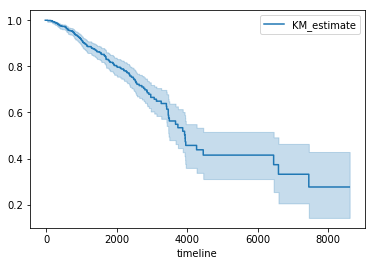

In [131]:
kmf = KaplanMeierFitter()
kmf.fit(df["survival"], df["event"]) #TODO : tell lifelines if the patient is censored or dead 
kmf.plot()

In [132]:
cph = CoxPHFitter()
cph.fit(df, duration_col='survival', event_col='event', show_progress=True)


cph.print_summary() 

Iteration 1: norm_delta = 0.23670, step_size = 0.95000, ll = -867.53103, newton_decrement = 5.74289, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.01590, step_size = 0.95000, ll = -861.81855, newton_decrement = 0.02314, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.00084, step_size = 0.95000, ll = -861.79543, newton_decrement = 0.00006, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.00004, step_size = 0.95000, ll = -861.79536, newton_decrement = 0.00000, seconds_since_start = 0.1
Convergence completed after 4 iterations.
<lifelines.CoxPHFitter: fitted with 1083 observations, 930 censored>
      duration col = 'survival'
         event col = 'event'
number of subjects = 1083
  number of events = 153
    log-likelihood = -861.80
  time fit was run = 2019-01-19 16:30:18 UTC

---
                  coef  exp(coef)  se(coef)     z    p  log(p)  lower 0.95  upper 0.95   
expressionNCKAP1  0.21       1.24      0.19  1.10 0.27   -1.30       -0.17        0.59   
expression

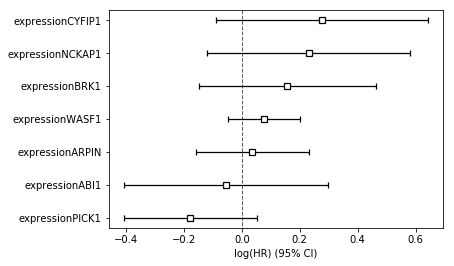

In [12]:
cph.plot()

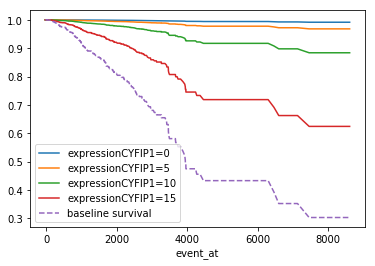

In [153]:
cph.plot_covariate_groups('expressionCYFIP1', [0, 5, 10, 15])

## The concordance and log-likelihood indicate that the model do not fit very well : let's check the assumptions for cox regression

In [14]:
cph.check_assumptions(df)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1173 but corresponding boolean dimension is 1203

## TODO : do we have to remove tumors that are not Primary tumors from the list ? make the same transformation than Marc Lavielle, check assumption for Cox Regression, use other form of gene expression (RNAseq) to compare, use other datasets

Liens : 

objectifs en cours : https://docs.google.com/document/d/1A5wxgQ_ZPry4aRH1BsmdbmPJfJoIsy5sa-4P5RmWaTs/edit


dossier partagé : https://drive.google.com/drive/u/0/folders/1HotcSiF2BzDuzXMhKNX1p-7lI1U_3UQ9

rapport : https://www.overleaf.com/project/5c34f6b7f99dfe3f36bf3a55
